In [9]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,       
    rotation_range=20,    
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))


test_dir = os.path.join(BASE_DIR, "data", "preprocessed_split_2","test")
train_dir = os.path.join(BASE_DIR, "data", "preprocessed_split_2","train")
val_dir = os.path.join(BASE_DIR, "data", "preprocessed_split_2","val")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),   
    batch_size=16,
    class_mode='binary'  ,
    color_mode='grayscale' 
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='grayscale' 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='grayscale' ,
    shuffle=False
)




Found 2315 images belonging to 2 classes.
Found 661 images belonging to 2 classes.
Found 333 images belonging to 2 classes.


In [6]:
base_model = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,1)
)


In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


In [10]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", "precision", "recall"]
)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)


In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop,lr_reduce]
)


Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1105s 8s/step - accuracy: 0.9564 - loss: 0.1328 - precision: 0.9697 - recall: 0.9443 - val_accuracy: 0.9652 - val_loss: 0.1201 - val_precision: 0.9646 - val_recall: 0.9675 - learning_rate: 1.0000e-04
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 937s 6s/step - accuracy: 0.9616 - loss: 0.1056 - precision: 0.9716 - recall: 0.9527 - val_accuracy: 0.9667 - val_loss: 0.0780 - val_precision: 0.9969 - val_recall: 0.9379 - learning_rate: 1.0000e-04
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 781s 5s/step - accuracy: 0.9603 - loss: 0.1043 - precision: 0.9675 - recall: 0.9544 - val_accuracy: 0.9682 - val_loss: 0.0906 - val_precision: 0.9877 - val_recall: 0.9497 - learning_rate: 1.0000e-04
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1758s 12s/step - accuracy: 0.9659 - loss: 0.0936 - precision: 0.9726 - recall: 0.9603 - val_accuracy: 0.9622 - val_loss: 0.0899 - val_precision: 0.9757 - val_recall: 0.9497 - learning_rate: 1.0000e-04
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 8

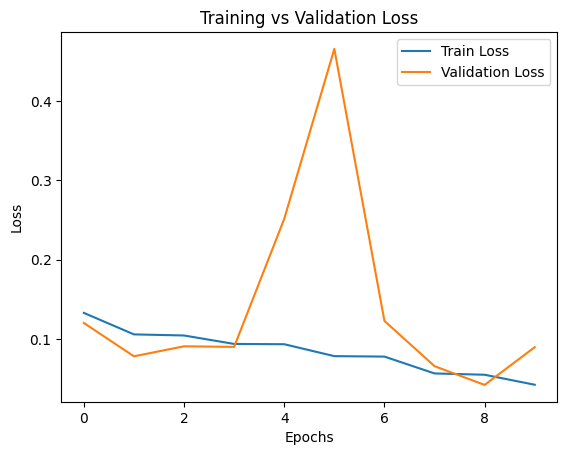

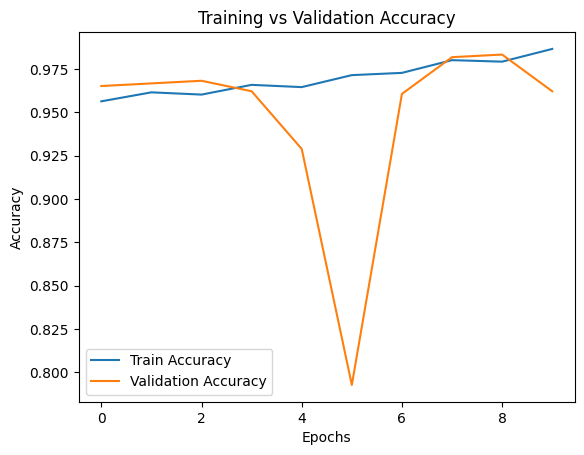

In [13]:
import matplotlib.pyplot as plt

# -------- LOSS --------
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# -------- ACCURACY --------
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_generator.reset()

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 520ms/step


In [15]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Test Metrics")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")


Test Metrics
Accuracy  : 0.9880
Precision : 0.9941
Recall    : 0.9825
F1-score  : 0.9882


In [16]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_dir = os.path.join(BASE_DIR, "models")

os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, "DenseNet_trained.keras"))